# Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
	* [2.1 Data Structure](#2.1-Data-Structure)
	* [2.2 Missing Values](#2.2-Missing-Values)
	* [2.3 Analysis of Passengers](#2.3-Analysis-of-Passengers)
	* [2.4 Analysis of Survival Priorities](#2.4-Analysis-of-Survival-Priorities)
		* [Partial assosiation: Survived vs Pclass with control on Sex](#Partial-assosiation:-Survived-vs-Pclass-with-control-on-Sex)
		* [Gender Difference in Teen Group](#Gender-Difference-in-Teen-Group)
* [3. Model Based Analysis](#3.-Model-Based-Analysis)
	* [3.1 Imputation of Missing Values](#3.1-Imputation-of-Missing-Values)
	* [3.2 Logistic Regression, Decision Trees and Random Forest](#3.2-Logistic-Regression,-Decision-Trees-and-Random-Forest)
		* [Decision Tree and Random Forest](#Decision-Tree-and-Random-Forest)
		* [Logistic regression](#Logistic-regression)
	* [3.3 Model Survival Probability](#3.3-Model-Survival-Probability)
* [4. Summary](#4.-Summary)


# 1. Introduction

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, many recourses state that some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Data for this analysis was taken from Kaggle competition Titanic: Machine Learning from Disaster. This dataset consists of passenger records, which include information about age, gender, class and etc. 

There are a lot of different question that one can ask about Titanic passengers, in further analysis we will be focused on two main questions:

* Many articles state that passengers traveling first class on Titanic were more likely to survive than other passengers. One can find the number of 44 percent as a difference. 
We will consider influence of class on survivorship from different perspectives and try to come up with some comparison numbers.

* In compliance with the law of the sea, women and children boarded the boats first; only when there were no women or children nearby were men permitted to board. We will try to find out what age was assumed to be child age. More specifically, at what age difference between survivorship for girls and boys become apparent. 






# 2. Exploratory Data Analysis

## 2.1 Data Structure

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sts

%matplotlib inline


In [79]:
data = pd.read_csv("data/train.csv")

In [80]:
data.Pclass = data.Pclass.astype("category")

In [81]:
data.shape

(891, 12)

In [82]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Dataset contains information about 891 Titanic passengers.
Each passenger is described by 12 variables. Among the most informative:

Categorical variables
 * Survived 
 * Pclass
 * Sex
 * Cabin
 * Embarked

Continuous variables 
 * Age
 * SibSp
 * Parch
 * Fare
 
Full name and ticket code are also provided for each passenger. 

In [83]:
cat_columns = ["Pclass", "Sex", "Embarked"]
num_columns = ["Age", "SibSp", "Parch", "Survived"]

data.describe()[num_columns].transpose()

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,0.523008,1.102743,0.00,0.000,0.0,1.0,8.0
Parch,891.0,0.381594,0.806057,0.00,0.000,0.0,0.0,6.0
Survived,891.0,0.383838,0.486592,0.00,0.000,0.0,1.0,1.0


In [84]:
data.describe(include=['O', 'category'])[cat_columns].transpose()

,count,unique,top,freq
Pclass,891,3,3,491
Sex,891,2,male,577
Embarked,889,3,S,644


Data Structure Summary:
* 891 passengers, 11 informative variables (excluded passenger id)
    * 2 text variables: Name, Ticket
    * 5 categorical variables
    * 4 Continuous variables
   
   
* Target variable Survived indicates whether passenger survived (value 1) or not (value 0)

## 2.2 Missing Values

In [85]:
data_null = data.isnull().sum()
res = pd.concat([data_null, data_null / data.shape[0]], axis=1)
res.columns = [["# nulls", "% nulls"]]
res[res["# nulls"]!=0]

,# nulls,% nulls
Age,177,0.198653
Cabin,687,0.771044
Embarked,2,0.002245


For nearly 20% of passengers Age value is missed, for 77% of passengers there is no information about Cabin.

Next we will analyze if the fact of "missed value" is related to survivorship. This dependence may occur if information about age or cabin was partly collected from survived passengers.

We will define two indicator variables: is_age and is_cabin. These variables will equal 'Yes' if corresponding value is not missed and 'No' otherwise.

In [86]:
data["is_age"] = 1
data.loc[data.Age.isnull(), "is_age"] = 0
data["is_cabin"] = 1
data.loc[data.Cabin.isnull(), "is_cabin"] = 0
data["Survived (y/n)"] = np.where(data.Survived==1,"Yes","No")

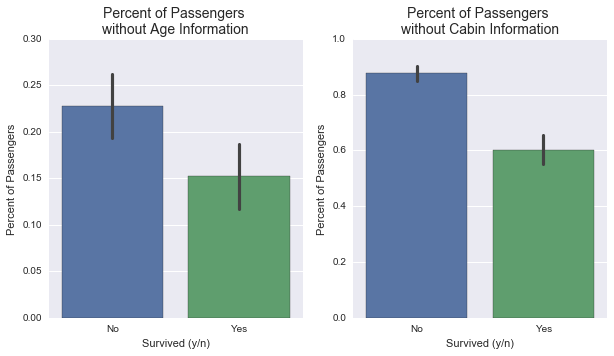

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

sns.barplot(x="Survived (y/n)", y="is_age", data=data, estimator=lambda s: 1-np.mean(s), ax=ax1)
sns.barplot(x="Survived (y/n)", y="is_cabin", data=data, estimator=lambda s: 1-np.mean(s),  ax=ax2)
ax1.set_title("Percent of Passengers \nwithout Age Information", size=14)
ax2.set_title("Percent of Passengers \nwithout Cabin Information", size=14)
ax1.set_ylabel("Percent of Passengers")
ax2.set_ylabel("Percent of Passengers")

Figure above shows separately percent of passengers with missed age and missed cabin in "Survived" and "Not Survived" groups.

Next we will perform Chi-Squared test of independence. Here we will find out whether is_age and is_cabin are independent from Survived.  
Each test will consider null hypothesis that there is no association between the fact that age (cabin) information is provided and the fact that passenger survived. An alternative hypotheses states that associations exist.

In [88]:
res_age = sts.chi2_contingency(pd.crosstab(index=data.Survived, columns=data.is_age ) )
res_cabin = sts.chi2_contingency(pd.crosstab(index=data.Survived, columns=data.is_cabin ) )

k = 2
n = data.shape[0]
cram_v_age = np.sqrt(res_age[0]/n/(k-1))
cram_v_cabin = np.sqrt(res_cabin[0]/n/(k-1))

print "is_age\t\t Chi-Sq stat: %.4f, p-value: %.4f, Cramer`s V: %.4f" % (res_age[0], res_age[1], cram_v_age)
print "is_cabin\t Chi-Sq stat: %.4f, p-value: %.4f, Cramer`s V: %.4f" % (res_cabin[0], res_cabin[1], cram_v_cabin)


is_age		 Chi-Sq stat: 7.1060, p-value: 0.0077, Cramer`s V: 0.0893
is_cabin	 Chi-Sq stat: 87.9415, p-value: 0.0000, Cramer`s V: 0.3142


We can reject null hypothesis of independence for both tests. As indicated by Cramer`s V measure association between survivorship and is_cabin is quite strong, although association between survivorship and is_age is weak. 


We will not use cabin information in further analysis, age missing values will be inputed in next sections.

## 2.3 Analysis of Passengers

In this section we will try to understand who traveled on Titanic.

For further analysis we will add the following new features:
* Family size - size of family calculated as a sum of SibSp and Parch, family size 1 means that passenger traveled without family.
* We will consider three family types: Single (passenger traveled without family), Medium Family (family with 2-4 members), Big Family (family with more than 4 members)
* We will consider three age groups: child (under 12 years), teen (13-18 years), adults (older than 18 yeras)

Note that teenager is quite modern definition, this group of passengers will be of special intereset in this investigation. 

In [89]:
data["Family_size"] = data.SibSp + data.Parch + 1
data["status"] = np.where(data.Family_size>1, "With_Family", "Single")

In [90]:
data["age_group"] = pd.cut(data.Age, bins=[0, 12, 18, 100], labels=["child", "teen", "adult"])
data["fam_status"] = pd.cut(data.Family_size, bins=[0, 1, 4, 15], labels=["Single", "Medium Family", "Big Family"])

First we will consider distribution of all passengers among different classes and sex.

In [91]:
def get_norm_value_counts(gr_col, df, up_col=None):
    norm_vc = df[gr_col].value_counts(normalize=True).rename("perc")
    if not isinstance(norm_vc.index, pd.core.index.MultiIndex):
        norm_vc.index.name = gr_col

    return norm_vc.reset_index()

In [92]:
sex_gr = get_norm_value_counts("Sex", data)
class_gr = get_norm_value_counts("Pclass", data) 
gr = data.groupby("Pclass")
class_sex_gr = get_norm_value_counts("Sex", gr)

print sex_gr
print "\n", class_gr.sort_values(by="Pclass")
print "\n", class_sex_gr.sort_values(by="Pclass")

      Sex      perc
0    male  0.647587
1  female  0.352413

  Pclass      perc
1      1  0.242424
2      2  0.206510
0      3  0.551066

  Pclass     Sex      perc
0      1    male  0.564815
1      1  female  0.435185
2      2    male  0.586957
3      2  female  0.413043
4      3    male  0.706721
5      3  female  0.293279


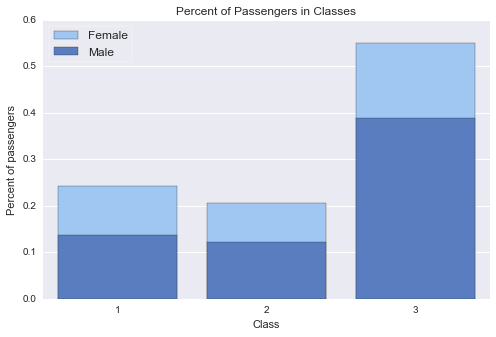

In [93]:
male_pclass_gr = data[data.Sex=="male"].Pclass.value_counts()/data.shape[0]
male_pclass_gr = male_pclass_gr.reset_index()
male_pclass_gr.columns = ["Pclass", "perc"]

fig, ax = plt.subplots(figsize=(8,5))

sns.set_color_codes("pastel")
sns.barplot(x="Pclass", y="perc", data=class_gr, label = "Female", color="b")
sns.set_color_codes("muted")
sns.barplot(x="Pclass", y="perc", data=male_pclass_gr, label="Male", color="b")
ax.legend(ncol=1, loc="upper left", frameon=True, fontsize='12')
ax.set(ylabel="Percent of passengers",
       title="Percent of Passengers in Classes",
       xlabel="Class")

sns.despine(left=True, bottom=True)


Most passengers traveled in third class (55%), difference between first and second classes is not so significant (24% and 21% respectively). There were more male passengers (65%). In first and second classes proportion between male and female passengers is nearly the same (nearly 56% males), but in third class there were much more male passengers: 71%.

Next we will consider family types and age groups.

In [94]:
fam_status_gr = get_norm_value_counts("fam_status", data)
age_group_gr = get_norm_value_counts("age_group", data[data.Age.notnull()])

print fam_status_gr
print "\n", age_group_gr

      fam_status      perc
0         Single  0.602694
1  Medium Family  0.327722
2     Big Family  0.069585

  age_group      perc
0     adult  0.805322
1      teen  0.098039
2     child  0.096639


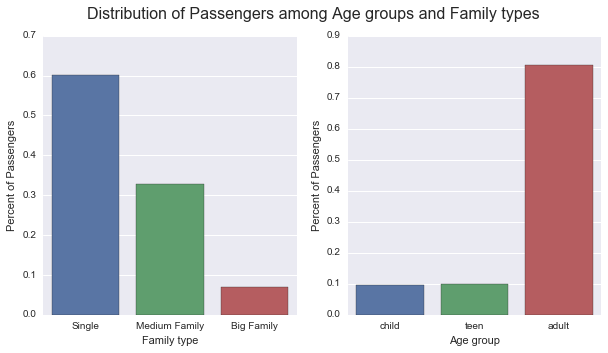

In [95]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.barplot(x="fam_status", y="perc", data=fam_status_gr, ax = ax[0])
sns.barplot(x="age_group", y="perc", data=age_group_gr, ax = ax[1])

fig.suptitle("Distribution of Passengers among Age groups and Family types", fontsize=16)
ax[0].set_ylabel("Percent of Passengers")
ax[1].set_ylabel("Percent of Passengers")
ax[0].set_xlabel("Family type")
ax[1].set_xlabel("Age group")



Big families were not common (only 7% of passengers traveled with big families), nearly 60% of passengers traveled without families (Single category). Nearly 80% of passengers were adults, 10% - children and 10% - teenagers. 

Were these proportions nearly the same in each class? Next we will consider different types of families and age groups in each class separately. 

In [96]:
gr = data.groupby("Pclass")
class_age_group_gr = get_norm_value_counts("age_group", data[data.Age.notnull()].groupby("Pclass"), ["Pclass"])
class_fam_status_gr = get_norm_value_counts("fam_status", gr, ["Pclass"])

print class_age_group_gr.sort_values(by=["age_group", "Pclass"])
print "\n", class_fam_status_gr

  Pclass age_group      perc
0      1     adult  0.913978
3      2     adult  0.832370
6      3     adult  0.735211
2      1     child  0.021505
4      2     child  0.098266
7      3     child  0.135211
1      1      teen  0.064516
5      2      teen  0.069364
8      3      teen  0.129577

  Pclass     fam_status      perc
0      1         Single  0.504630
1      1  Medium Family  0.467593
2      1     Big Family  0.027778
3      2         Single  0.565217
4      2  Medium Family  0.423913
5      2     Big Family  0.010870
6      3         Single  0.659878
7      3  Medium Family  0.230143
8      3     Big Family  0.109980


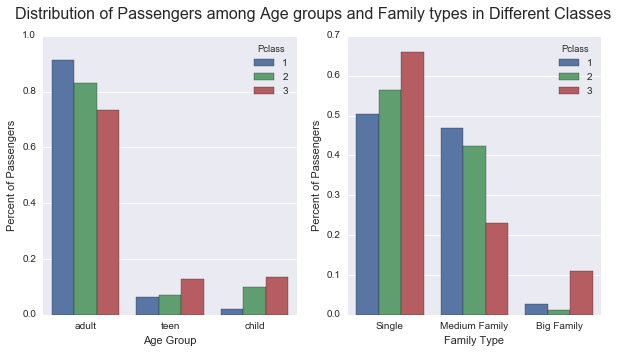

In [97]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

sns.barplot(hue="Pclass", y="perc", x="age_group", data=class_age_group_gr, ax = ax[0])
sns.barplot(hue="Pclass", y="perc", x="fam_status",  data=class_fam_status_gr, ax = ax[1])

fig.suptitle("Distribution of Passengers among Age groups and Family types in Different Classes", fontsize=16)
ax[0].set_ylabel("Percent of Passengers")
ax[1].set_ylabel("Percent of Passengers")
ax[0].set_xlabel("Age Group")
ax[1].set_xlabel("Family Type")


Children were a very tiny part of 1st class (only 2%), at the same time in third class 14% of passengers were children. Medium families were quite typical for first and second classes, but big families were very rare. In third class 11% of passengers traveled with big families, medium families were not so common (only 23% in comparison with 47% and 42% in first and second classes). Nearly 66% of passengers in third class traveled without family.  

Next we will look at the age group "teen" separately and analyse class and sex distributions.

In [98]:
teen_gr = data[data.age_group=="teen"].groupby("Sex") 
teen_sex_class_gr = get_norm_value_counts("Pclass", teen_gr, ["Sex"])
teen_sex_fam_status_gr = get_norm_value_counts("fam_status", teen_gr, ["Sex"])

teen_sex_class_gr = teen_sex_class_gr.sort_values(by=["Sex", "Pclass"])
teen_sex_fam_status_gr = teen_sex_fam_status_gr.sort_values(by=["Sex", "fam_status"])
print teen_sex_class_gr
print "\n", teen_sex_fam_status_gr

      Sex  Pclass      perc
1  female       1  0.277778
2  female       2  0.166667
0  female       3  0.555556
5    male       1  0.058824
4    male       2  0.176471
3    male       3  0.764706

      Sex     fam_status      perc
2  female     Big Family  0.083333
0  female  Medium Family  0.527778
1  female         Single  0.388889
5    male     Big Family  0.117647
4    male  Medium Family  0.294118
3    male         Single  0.588235


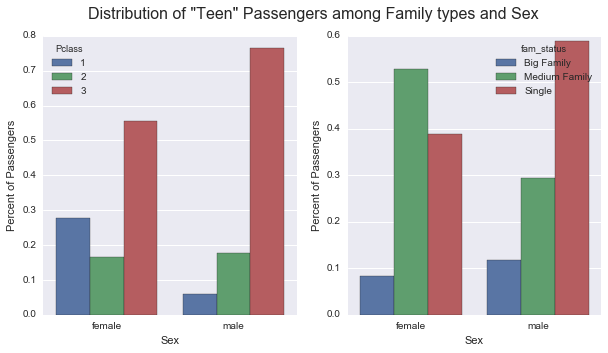

In [99]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

sns.barplot(x="Sex", y="perc", hue="Pclass", data=teen_sex_class_gr, ax=ax[0])
sns.barplot(x="Sex", y="perc", hue="fam_status", data= teen_sex_fam_status_gr, ax=ax[1])

fig.suptitle("Distribution of \"Teen\" Passengers among Family types and Sex", fontsize=16)
ax[0].set_ylabel("Percent of Passengers")
ax[1].set_ylabel("Percent of Passengers")


Most teen girls and boys were from 3rd class (the same tendency for all passengers, most passengers are from third class).

Summary:
* Unbalanced distribution between classes : 55% traveled in 3rd class
* Nearly 65% male passengers, 35% female passengers.
* Proportion between men and women were nearly the same in 1st and 2nd classes: nearly 57% men and 43% women. In 3rd class 71% were men and only 29% were women.
* There were more children in 3rd class 

## 2.4 Analysis of Survival Priorities

Only 38% of passangers survived.

In [100]:
data.Survived.mean()

0.3838383838383838

Many resources point out that 1st class passengers had much more chances to survive than other passengers. This statement can be considered quite controversial. Class in this context refers to accommodation class, but it is closely related to social class and income level at the same time. Were 3rd class passengers discriminated in some way? 

In [101]:
print "Survival rate for differnt classes"
print data.groupby("Pclass")["Survived"].mean()
print "\nSurvival rate for men and women"
print data.groupby("Sex")["Survived"].mean()

Survival rate for differnt classes
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

Survival rate for men and women
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


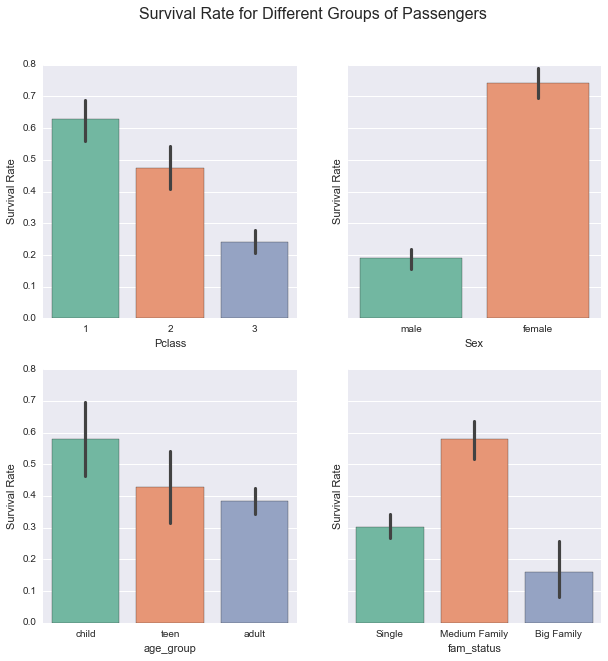

In [102]:
fig, ax = plt.subplots(2,2, sharey=True, figsize=(10,10))

pal = sns.color_palette("Set2", 10)
sns.barplot(x="Pclass", y="Survived", data=data, ax=ax[0,0], palette=pal)
sns.barplot(x="Sex", y="Survived", data=data, ax=ax[0,1], palette=pal)
sns.barplot(x="age_group", y="Survived", data=data, ax=ax[1, 0], palette=pal)
sns.barplot(x="fam_status", y="Survived", data=data, ax=ax[1, 1], palette=pal)
fig.suptitle("Survival Rate for Different Groups of Passengers", fontsize=16)
for i,j in zip([0,1,0, 1], [0, 0, 1, 1]):
    ax[i,j].set_ylabel("Survival Rate")

Left top figure shows relationship between accommodation class and survival rate. Survival rate for 1st class passengers is 63% which exceeds survival rate for 3rd class passengers on 39 percent points and overall survival rate (38%) on 25%.

At the same time right top figure shows huge difference between survival rates for men and women, the rule "women and children first" were definitely in place. Only 19% men survived while 74% women survived. We will also consider age and children category later.
 

Children had higher survival rate than teens and adults, at the same time survival rates for teens and adults are quite close.

We can assume that low survival rate for third class is a consequence of unbalance in number of male and female passengers. Note that in third class 71% passengers were male. However next plot shows that for women the class also mattered.

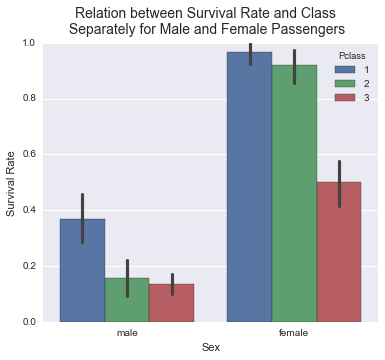

In [103]:
fig = plt.figure(figsize=(6,5))
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data)
plt.ylabel("Survival Rate")
fig.suptitle("Relation between Survival Rate and Class\n Separately for Male and Female Passengers", fontsize=14, y=1)

Survival rate for female passengers is much lower in comparison with other classes. The same for male passengers: survival rate for first class is higher. We will compare these differences more accurately in the next section

### Partial assosiation: Survived vs Pclass with control on Sex

Both Pclass and Sex seem to be strongly related to the target variable Survived. Here we will distinguish between their separate effects on survivorship. 

Percentages of survived passengers calculated separately for all passengers, male and female passengers.

In [104]:
comp_tab = data.groupby(["Sex", "Pclass"])["Survived"].mean().reset_index() \
                    .pivot(index="Sex", columns="Pclass", values="Survived")
comp_tab.loc["all"] = data.groupby("Pclass")["Survived"].mean()
comp_tab

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447
all,0.629630,0.472826,0.242363


Next we will perform separately three Chi-Squared tests, the first test will deal with the whole sample, next two tests will consider males and females separately. Each test will test hypothesis of independence for Survived and Pclass.

In [105]:
res_all = sts.chi2_contingency(pd.crosstab(data.Survived, data.Pclass))
res_male = sts.chi2_contingency(pd.crosstab(data[data.Sex=="male"].Survived, data[data.Sex=="male"].Pclass))
res_female = sts.chi2_contingency(pd.crosstab(data[data.Sex=="female"].Survived, data[data.Sex=="female"].Pclass))

k = 2
n = data.shape[0]
cram_v_all = np.sqrt(res_all[0]/len(data)/(k-1))
cram_v_male = np.sqrt(res_male[0]/len(data[data.Sex=="male"])/(k-1))
cram_v_female = np.sqrt(res_female[0]/len(data[data.Sex=="female"])/(k-1))

print "Survived vs Pclass\t\t Chi-Sq stat: %.4f, p-value: %.4f, Cramer`s V: %.4f" % \
                                                            (res_all[0], res_all[1], cram_v_all)
print "Survived vs Pclass (Sex=male)\t Chi-Sq stat: %.4f, p-value: %.4f, Cramer`s V: %.4f" % \
                                                            (res_male[0], res_male[1], cram_v_male) 
print "Survived vs Pclass (Sex=female)\t Chi-Sq stat: %.4f, p-value: %.4f, Cramer`s V: %.4f" % \
                                                            (res_female[0], res_female[1], cram_v_female)

Survived vs Pclass		 Chi-Sq stat: 102.8890, p-value: 0.0000, Cramer`s V: 0.3398
Survived vs Pclass (Sex=male)	 Chi-Sq stat: 32.9541, p-value: 0.0000, Cramer`s V: 0.2390
Survived vs Pclass (Sex=female)	 Chi-Sq stat: 81.8866, p-value: 0.0000, Cramer`s V: 0.5107


Hypothesis of independence between Survived and Pclass can be rejected at the 1% level of significance for all passengers and for both males and females. This means that Pclass has effect on Survived in all situations: when Sex is held constant and when it is not. 

It is interesting to note that association between survivorship and class is comparatively stronger among female passengers then among male passengers as indicated by Cramer`s V measure of association. 

According to the table above (percentages of survived passengers calculated separately for all passengers, male and female passengers):
 * Survival rates among male passengers are quite similar for 2nd and 3rd classes, but differ significantly from 1st class.

 * Survival rates among female passengers are quite similar for 1st and 2nd classes, but duffer significantly from 3rd class

What if proportion of men and women in each class were equal? How will survivorship rates or in other words probabilities to survive change in this situation? 
To answer this question we will use the following formula (Low of total probability):

$$
P(S\ |\ Pclass = k) = P(Male\ |\ Pclass = k)\ P(S\ |\ Pclass=k, Sex=Male) + P(Female\ |\ Pclass = k)\ P(S\ |\ Pclass=k, Sex=Female),
$$

where $k=1,2,3,\ P(S\ |\ Pclass = k)$ - conditional probability to survive for passenger from class $k$. 

Equal proportion of men and women means that $P(Male\ |\ Pclass = k) = P(Female\ |\ Pclass = k)=0.5,\ k=1,2,3$.

In [106]:
comp_tab.loc["all(equal male and female)"]=comp_tab.loc[["female", "male"],:].mean()

In [107]:
comp_tab

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447
all,0.629630,0.472826,0.242363
all(equal male and female),0.668469,0.539230,0.317723


Last row in the table above shows survivival rates in different classes for "hypothetical" situation when proporion of men and women is equal in each class. Note that in comparison with real numbers this rate is higher in 3rd class (excluded influence of  gender unbalance ) and in 2nd class. Difference between 1st and 3rd classes is still very big and can be estimates as 35%. 

Important thing to remember is that performed test confirms only relationship between class, sex and survival rate, but it does not confirm causality. 

### Gender Difference in Teen Group

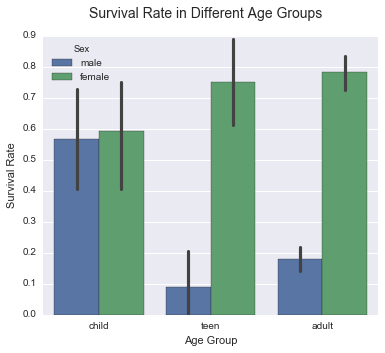

In [108]:
fig = plt.figure(figsize=(6,5))

sns.barplot(x="age_group", y="Survived", hue="Sex", data=data)
plt.ylabel("Survival Rate")
plt.xlabel("Age Group")
fig.suptitle("Survival Rate in Different Age Groups", fontsize=14)


For children gender did not mattered, both boys and girls were prioritized. However teens alrady follow the pattern for adults: gender difference seems to be very strong.  

# 3. Model Based Analysis

## 3.1 Imputation of Missing Values

If we see "Miss" in a passenger name, than probably this passenger was younger than someone with "Mrs" in her name.
To check this idea we will extract titles from names.

In [109]:
import re
pattern = r'^(\w+),\s?(?:(\w+)\.)?'

In [110]:
def get_title(s):
    pattern = r"^([\w\s'-]+),\s?(?:(\w+)\.)?"
    title = np.nan
    match = re.search(pattern, s)
    if match:
        title = match.group(2)
    return title

data["name_title"] = data.Name.apply(get_title)

In [111]:
data.name_title.value_counts(dropna=False)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Lady          1
Jonkheer      1
Don           1
Ms            1
Mme           1
Capt          1
Sir           1
NaN           1
Name: name_title, dtype: int64

In [112]:
def get_title_group(title):
    if pd.isnull(title):
        return title
    
    title_lc = title.lower()
    title_gr = "Other"
    dict_gr = {
        "Mr" : ["mr", "don"],
        "Mrs" : ["mrs", "mml"],
        "Miss" : ["miss", "mlle"],
        "Master" : ["master"]
        
    }
    for group, values in dict_gr.items():
        if title_lc in values:
            title_gr = group
    return title_gr

In [113]:
data["name_title_gr"] = data.name_title.apply(get_title_group)

In [114]:
data.name_title_gr.value_counts()

Mr        518
Miss      184
Mrs       125
Master     40
Other      23
Name: name_title_gr, dtype: int64

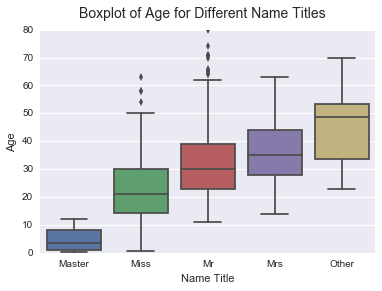

In [176]:
fig = plt.figure()
sns.boxplot(x="name_title_gr", y="Age", data=data, order=["Master", "Miss", "Mr", "Mrs", "Other"])
plt.xlabel("Name Title")
fig.suptitle("Boxplot of Age for Different Name Titles", fontsize=14)

In [116]:
def inpute_age(df, field):
    df_new = df.copy()
    inpute_values = df_new[df_new.Age.notnull()].groupby(field)["Age"].median().to_dict()
    for f, val in inpute_values.items():
        df_new.loc[(df_new[field]==f)&(df_new.Age.isnull()),"Age"] = val 
    return df_new

In [117]:
data_notnull = inpute_age(data,  "name_title_gr")

We have imputed missing values using information about name titles.  

## 3.2 Logistic Regression, Decision Trees and Random Forest

### Decision Tree and Random Forest

First we will construct simple decision tree where Survived will be used as a target variable. We will use GridSearch in order to find optimal parameters, 3-fold cross validation will be used for performance estimation. 

In [118]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, cross_validation
from sklearn.grid_search import GridSearchCV
from IPython.display import Image

In [119]:
#data_notnull = data[data.Age.notnull()]
Xy_df = data_notnull[["Survived", "Age", "Sex", "Pclass", "Family_size", "SibSp"]]
X_df = data_notnull[["Age", "Sex", "Pclass", "Family_size", "SibSp"]]
y = data_notnull.Survived.values

In [120]:
X_enc_df = pd.get_dummies(X_df, columns=["Sex", "Pclass"], drop_first=True)
X_enc_df_full = pd.get_dummies(X_df, columns=["Sex", "Pclass"])

First we will train quite small decision tree which will be easy for understanding and interpretation. 

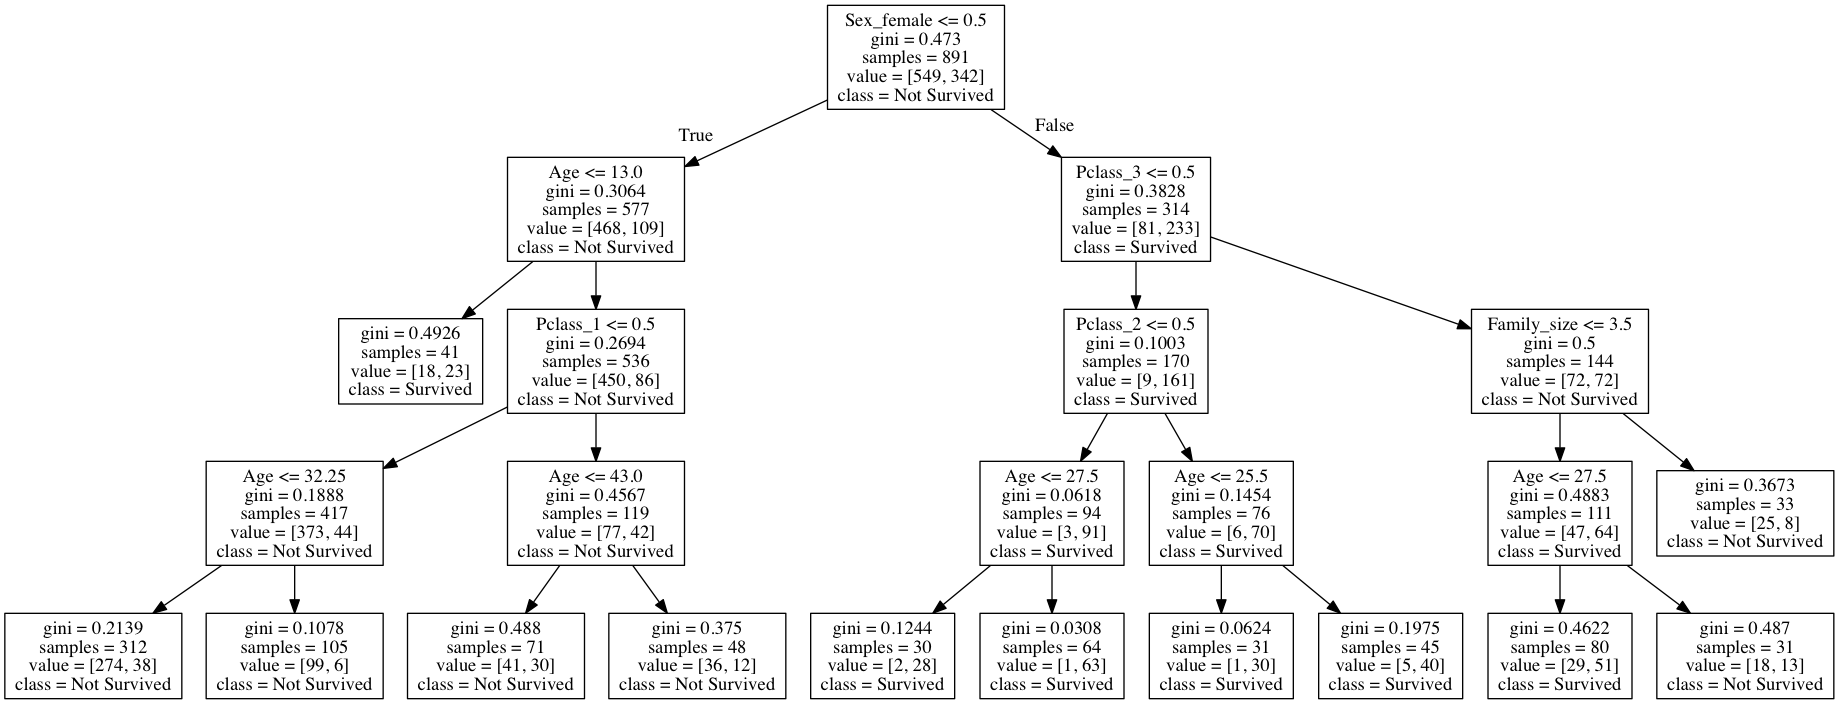

In [121]:
clf = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=30)
clf = clf.fit(X_enc_df_full, y)

tree.export_graphviz(clf, "tree.dot", feature_names=X_enc_df_full.columns,  class_names = ["Not Survived", "Survived"])
! dot -Tpng tree.dot > tree.png
Image(filename="tree.png")

It is interesting to note that Sex is the first feature for split. If passenger is a male than the next split is based on age and separates out group of passengers who are younger than 13 years old. These male passengers have label "Survived". For female passengers next split is related to class and determines whether the passenger is from 3rd class or not. 

Next we will find optimal parameter values and consider corresponding classifier. 

In [122]:
clf_tree = tree.DecisionTreeClassifier()
param_grid = {
    "max_depth" : np.arange(4, 21),
    "min_samples_leaf" : np.arange(10, 51, 5)
}
cv_srch = GridSearchCV(clf_tree, param_grid, scoring="f1", cv=3) 
cv_srch.fit(X_enc_df_full, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]), 'min_samples_leaf': array([10, 15, 20, 25, 30, 35, 40, 45, 50])},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

Found optimal parameters:

In [123]:
print cv_srch.best_params_
print cv_srch.best_score_

{'max_depth': 10, 'min_samples_leaf': 10}
0.749137137225


In [124]:
clf_tree_opt = cv_srch.best_estimator_

Main metrics of optimal classifier (calculated from comparison of real and predicted values of target variable):

In [125]:
print metrics.classification_report(y, clf_tree_opt.predict(X_enc_df_full))

             precision    recall  f1-score   support

          0       0.85      0.91      0.88       549
          1       0.84      0.75      0.79       342

avg / total       0.85      0.85      0.85       891



Next we can estimate feature importance

In [126]:
sorted (zip (X_enc_df_full.columns, clf_tree_opt.feature_importances_ ), key=lambda t: t[1], reverse=True)

[('Sex_male', 0.53237634578233173),
 ('Age', 0.1596636991696368),
 ('Pclass_3', 0.13485867166297832),
 ('SibSp', 0.075918376117960595),
 ('Pclass_1', 0.048500242112917029),
 ('Family_size', 0.04788719362184251),
 ('Pclass_2', 0.00079547153233289582),
 ('Sex_female', 0.0)]

Here again the most important questions are about Sex, Age and Class (in 3rd class or not) 


Next we will consider Random Forest, which is often more powerful classifier than simple decision tree.  

In [127]:
clf_rf = RandomForestClassifier()
param_grid = {
    "n_estimators" : np.arange(4,30,2)
}
cv_srch = GridSearchCV(clf_rf, param_grid, scoring="f1", cv=3) 
cv_srch.fit(X_enc_df_full, y)

print cv_srch.best_params_
print cv_srch.best_score_

{'n_estimators': 20}
0.734208971694


Main metrics comparison for two classifiers:

In [128]:
clf_rf_opt = cv_srch.best_estimator_
print metrics.classification_report(y, clf_tree_opt.predict(X_enc_df_full))
print metrics.classification_report(y, clf_rf_opt.predict(X_enc_df_full))

             precision    recall  f1-score   support

          0       0.85      0.91      0.88       549
          1       0.84      0.75      0.79       342

avg / total       0.85      0.85      0.85       891

             precision    recall  f1-score   support

          0       0.91      0.95      0.93       549
          1       0.91      0.85      0.88       342

avg / total       0.91      0.91      0.91       891



Random Forest Classifier performed better and expected to be more accurate for prediction. 

Feature importance according to Random Forest Classifier:

In [129]:
sorted (zip (X_enc_df_full.columns, clf_rf_opt.feature_importances_), key=lambda t:t[1], reverse=True)

[('Age', 0.40009912700496864),
 ('Sex_female', 0.20816416817656788),
 ('Sex_male', 0.13486209539168378),
 ('Family_size', 0.082336465893788638),
 ('Pclass_3', 0.065881879847228167),
 ('Pclass_1', 0.048193275798836865),
 ('SibSp', 0.044719109603048368),
 ('Pclass_2', 0.015743878283877553)]

According to this model the most important questions are about age, sex and family size.

### Logistic regression

In this section we will train logistic regression.

In [130]:
import statsmodels.api as sm 

In [131]:
import statsmodels.formula.api as smf

In [132]:
log_fit = smf.logit(formula="Survived ~ Age + C(Pclass) + C(Sex) + SibSp + np.power(Age,2) + C(Pclass):C(Sex)", \
                  data = Xy_df).fit()
log_fit.summary()

Optimization terminated successfully.
         Current function value: 0.417336
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Fri, 10 Jun 2016   Pseudo R-squ.:                  0.3733
Time:                        21:37:45   Log-Likelihood:                -371.85
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.191e-90
=================================================================================================
                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                         6.4563      0.763      8.463      0.000         4.961     7.952
C(Pclass)[T.2]                   -1.2391      0.733     -1.691      0.091        -2.675     0.197
C(Pclass)[T.3]                   -4.0765      0.631     -6.458      0.000        -5.314    -2.839
C(Sex)[T.male]                   -4.1065      0.624     -6.583      0.000        -5.329    -2.884
C(Pclass)[T.2]:C(Sex)[T.male]    -0.4120      0.809     -0.509      0.611        -1.997     1.173
C(Pclass)[T.3]:C(Sex)[T.male]     2.2706      0.667      3.407      0.001         0.964     3.577
Age                              -0.1179      0.023     -5.081      0.000        -0.163    -0.072
SibSp                            -0.4771      0.115     -4.135      0.000        -0.703    -0.251
np.power(Age, 2)                  0.0011      0.000      3.269      0.001         0.000     0.002
=================================================================================================
"""

In [133]:
log_fit.params

Intercept                        6.456281
C(Pclass)[T.2]                  -1.239072
C(Pclass)[T.3]                  -4.076471
C(Sex)[T.male]                  -4.106477
C(Pclass)[T.2]:C(Sex)[T.male]   -0.411955
C(Pclass)[T.3]:C(Sex)[T.male]    2.270580
Age                             -0.117894
SibSp                           -0.477122
np.power(Age, 2)                 0.001072
dtype: float64

Negative values of coefficients C(Pclass)[T.2] and C(Pclass)[T.3] mean that 1st class passengers had higher probability to survive than passengers from 2nd and 3rd classes. Being in 3rd class reduces log odds on 4.07. 
Difference between 1st and 2nd classes is not significant

Difference between males and females is indicated by negative coefficient -4.1 which is nearly the same in 1st and 2nd classes. However in third class coefficient is also negative, but lower in absolute value: -1.86 (taking interaction term into account).

Males had significantly lower probability to survive than females (C(Sex)[T.male] = -4.106477). However since we included interaction terms Class x Sex, we can give additional details. In 3rd class difference between probability to survive for men and women was lower than in other classes.

In [134]:
pred_y = map(lambda p: 1 if p>=0.5 else 0, log_fit.predict(exog = Xy_df))

Maint classification metrics:

In [135]:
print metrics.classification_report(y, pred_y, digits=4, target_names =["did not Survived", "Survived"])

                  precision    recall  f1-score   support

did not Survived     0.8032    0.9217    0.8584       549
        Survived     0.8352    0.6374    0.7231       342

     avg / total     0.8155    0.8126    0.8064       891



We can see that "Not Survived" group is better identified 

## 3.3 Model Survival Probability

Having prediction model we can calculate survival probability actually for any feature values, even if they were not presented in the dataset. This gives us an opportunity to get a better understanding of the data.

First we will create a grid of input features: Age, Family_size, SibSp, Sex, Pclass.

In [136]:
age_values = np.linspace(data.Age.min(), data.Age.max(), 100)
sex = [1, 0]
pclass = [1,2,3]
Family_size = data.Family_size.unique()
SibSp=data.SibSp.unique()

arr = np.array(np.meshgrid(age_values, Family_size, SibSp, sex, pclass)).T.reshape(-1,5)
df = pd.DataFrame(arr, columns = ["Age", "Family_size", "SibSp", "Sex", "Pclass"])
df["Sex"] = np.where(df.Sex==1, "male", "female")
df.Pclass = df.Pclass.astype("int")
df.SibSp = df.SibSp.astype("int")
df.Family_size = df.Family_size.astype('int')

In [137]:
#enc_df = pd.get_dummies(df, columns=["Sex", "Pclass"], drop_first=True)
enc_df_full = pd.get_dummies(df, columns=["Sex", "Pclass"])

In [138]:
#prob_surv = res.predict(exog = enc_df)
df["pr_surv_logit"] = log_fit.predict(exog = df)
df["pr_surv_dtree"] = zip(*clf_tree_opt.predict_proba(enc_df_full))[1]
df["pr_surv_rf"] = zip(*clf_rf_opt.predict_proba(enc_df_full))[1]


Next we would like to estimate relationship between probability to survive, age and sex. What should we do with all other features? For each tuple (Age, Sex) we will have a list of survival probabilities, each one corresponding to values of other features ( Pclass, Family_size and SibSp). We could just average that list and get one aggregate value of survival probability for a tuple (Age, Sex), but what will that actually mean? If we consider all triples (Pclass, Family_size and SibSp), will all of them have the same probability to appear? Of course not, for example, there were much less big families than single passengers in 1st class. It means that triple (1, 6, 5) is much less probable than (1,1,0). 
The right thing to do is to calculate weighted average of survival probabilities for all triples (Pclass, Family_size and SibSp) using probability of these triples as weights.

It means that we would like to know probability of each triple to appear, we can estimate it by counting how many triples with  the same values appear in the dataset. Next code is intended for that.

 

In [139]:
add_values = df[["Pclass", "Family_size", "SibSp"]].drop_duplicates(["Pclass", "Family_size", "SibSp"])

In [140]:
prob = []
n = len(data)
for i in np.arange(len(add_values)):
    val = add_values.iloc[i, :]
    k = len(data[(data.Pclass == val["Pclass"]) & \
                 (data.Family_size == val["Family_size"]) & \
                 (data.SibSp == val["SibSp"]) \
                ])
    if k==0:
        k = k + 1
        n = n + 1
    prob.append(k)
    
add_values["prob"] = np.array(prob) / float(n)

Now we have a data frame which contains all possible triples (Pclass, Family_size and SibSp) along with probability "prob" - probability that such combination will appear.Next we will group prepared grid by Age and Sex and calculated weighted average of survival probabilities for each model.

In [141]:
df_ext = pd.merge(df, add_values)

In [142]:
for col in ["pr_surv_logit", "pr_surv_dtree", "pr_surv_rf"]:
    df_ext[col + "_n"] = df_ext[col] * df_ext.prob

In [143]:
pr_mean = df_ext.groupby(["Sex", "Age"])[["pr_surv_logit_n", "pr_surv_dtree_n", "pr_surv_rf_n"]].sum().reset_index()

In [144]:
pr_mean.columns = ["Sex", "Age", "pr_surv_logit", "pr_surv_dtree", "pr_surv_rf"]

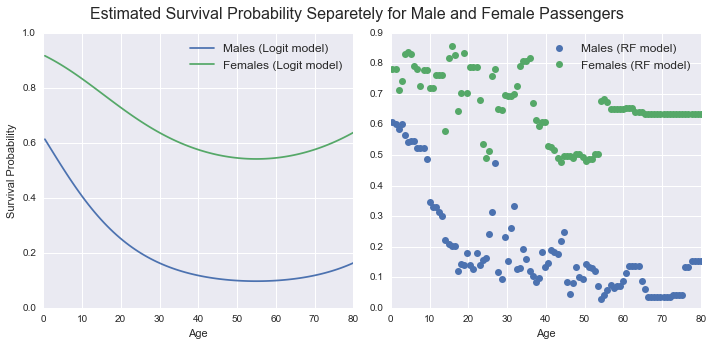

In [172]:
import matplotlib.gridspec as gridspec

is_male = pr_mean.Sex == "male"
is_female = pr_mean.Sex == "female"

fig = plt.figure(figsize=(10,5))
gs1 = gridspec.GridSpec(1, 2)
ax = [fig.add_subplot(ss) for ss in gs1]
fig.suptitle("Estimated Survival Probability Separetely for Male and Female Passengers", fontsize=16)

ax[0].plot(pr_mean[is_male].Age, pr_mean[is_male].pr_surv_logit, label="Males (Logit model)" )
ax[0].plot(pr_mean[is_female].Age, pr_mean[is_female].pr_surv_logit, label="Females (Logit model)" )
ax[0].legend(fontsize=12)
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Survival Probability")

ax[1].plot(pr_mean[is_male].Age, pr_mean[is_male].pr_surv_rf, 'o', label="Males (RF model)" )
ax[1].plot(pr_mean[is_female].Age, pr_mean[is_female].pr_surv_rf, 'o', label="Females (RF model)" )
ax[1].legend(fontsize=12)
ax[1].set_xlabel("Age")

gs1.tight_layout(fig, rect=[0, 0.03, 1, 0.95])  





We can see that as age increases survival probability decreases. Both models suggest that there is an age after which survival probability slightly goes up. Difference between male and female passengers also seems to increases with increase of age, indicating that little children were not discriminated by gender. According to Random Forest model we can suggest that threshold for "child age" is between 10 and 13 years.

# 4. Summary

According to provided data and conducted analysis passengers traveling first class were indeed more likely to survive than other passengers. Difference in survival rates between first and third classes is nearly 39% and between  first and second classes is 16%. One can argue that gender unbalance influenced survival statistics, but performed tests and calculations show that difference is significant. We have showed that even if there were equal proportion of men and women in each class, the  difference is still very hight and equals 35% for first and third classes. 

We have also analyzed three age groups: child (under 12 years), teen (13-18 years), adults (older than 18 years). A "teenager" is quite modern definition and probably did not exist in Titanic time. Analysis results show that these passengers is much closer to adults. We have seen that as age increases survival probability decreases and also increases difference between male and female passengers. We can point out age of 13 as a threshold, which appeared in Decision Tree model and indicated the "child age" for male passengers. For female passengers age did not appeared in the first place, because all female passengers women priority for rescue. 

Even though the dataset is quite small it adresses a lot of interesting questions. However we can point out the following  limitations of the analysis:

 * Provided dataset is not complete and does not have information about all passengers. Ticket information could be used to separate individual families (most families had the same ticket number), but since the whole dataset is not available we are not able to see all family members. For example we could check if families with male adult members had higher probability to survive or calculate how many families were separated (when only part of family survived).
 * For nearly 20% of passengers Age value is missed, for 77% of passengers there is no information about Cabin. Age is important variable and imputation of 20% of values of course adds some bias in analysis. It is not possible and does not make any sense to impute 77% of values of Cabin variable. However if we had information about Cabin, we could analyze if cabin location influence survivorship. 

# References



http://www.history.com/topics/titanic

https://www.kaggle.com/c/titanic